## Initializing Database

In [74]:
import numpy as np
import mygrad as mg

In [75]:
# run this cell to setup matplotlib, and also import the very important take_picture function from camera!
%matplotlib notebook
import matplotlib.pyplot as plt
from camera import take_picture
import numpy as np
import cv2

from facenet_models import FacenetModel


In [76]:
def cos_distance(d_avg, d_test):
    d_avg_normalized = d_avg / np.linalg.norm(d_avg)
    d_test_normalized = d_test / np.linalg.norm(d_test)
    
    # print(d_avg_normalized)
    # print(d_test_normalized)
    
    numerator = np.dot(d_avg_normalized, d_test_normalized)
    d_avg_mag = np.sqrt(np.dot(d_avg_normalized, d_avg_normalized))
    d_test_mag = np.sqrt(np.dot(d_test_normalized, d_test_normalized))
    
    return 1 - numerator # / (d_avg_mag * d_test_mag)

In [77]:
class Profile:
    
    def __init__(self, name="", vector_descriptors=None):
        self.name = name # the name of the person
        if vector_descriptors is None:
            vector_descriptors = []
        self.vector_descriptors = vector_descriptors # the vector descriptors of each face of the person in the database
        self.averageVD = 0
        
    def addPic(self, pic_vd):
        self.vector_descriptors.append(pic_vd)
        self.calculateAverageVD() # Initialize average VD
        
    def removePic(self, index = 0):
        #if len(vector_desciptors) == 0:
        self.vector_descriptors.pop(index)
        self.calculateAverageVD()
    
    def calculateAverageVD(self): # Calculates the average vector descriptor of the person for 
        if len(self.vector_descriptors) == 0:
            self.averageVD = 0
        else:
            self.averageVD = np.sum(self.vector_descriptors, axis=0)/len(self.vector_descriptors)

In [79]:
class Database:
    
    def __init__(self):
        self.storage = dict() 
        self.entries = []
        self.model = FacenetModel()
    
    def addEntry(self, *, pic_vd, name):
        if name not in self.storage:
            profile = Profile(name=name)
            profile.addPic(pic_vd)
            self.storage[name] = profile
            self.entries.append(name)
        else:
            self.storage[name].addPic(pic_vd)
    
    def removeEntry(self, *, index, name):
        self.storage[name].removePic(index)
    
    def removeProfile(self, *, name):
        self.entries.remove(name)
        if name not in self.storage:
            print("Tried to delete a non-existent key-value pair in self.storage!")
            exit()
        del self.storage[name]
        
    def match(self, sample_vd, cutoff = 0.5):
        matched_name = ""
        lowest_score = 50
        for entry in self.entries:
            dist = cos_distance(sample_vd, self.storage[entry].averageVD)
            print("Cosine Similarity for", entry, ":", dist)
            if dist <= cutoff and dist < lowest_score:
                lowest_score = dist
                matched_name = entry
        if matched_name == "":
            return "No one!"
        else:
            return matched_name
        
    def convertFacetoVD(self, pic, boxes): # Make sure f
        descriptor = self.model.compute_descriptors(pic, boxes) # Producing the descriptor vector
        descriptor = descriptor.reshape(512)
        return descriptor
    
    def convertPictoFaces(self, pic):
        # detect all faces in an image
        # returns a tuple of (boxes, probabilities, landmarks)
        # assumes ``pic`` is a numpy array of shape (R, C, 3) (RGB is the last dimension)
        #
        # If N faces are detected then arrays of N boxes, N probabilities, and N landmark-sets
        # are returned.
        boxes, probabilities, landmarks = self.model.detect(pic)
        return boxes, probabilities, landmarks
    
    def drawFaces(self, pic, boxes, probabilities, landmarks):
        # SHOWING FACE RECTANGLES
        from matplotlib.patches import Rectangle

        fig, ax = plt.subplots()
        ax.imshow(pic)

        for box, prob, landmark in zip(boxes, probabilities, landmarks):
            # draw the box on the screen
            ax.add_patch(Rectangle(box[:2], *(box[2:] - box[:2]), fill=None, lw=2, color="red"))

            # Get the landmarks/parts for the face in box d.
            # Draw the face landmarks on the screen.
            for i in range(len(landmark)):
                ax.plot(landmark[i, 0], landmark[i, 1], "+", color="blue")

In [80]:
db = Database()

## Adding Joe Biden Photo(s) to database

jb shape: (251, 201, 3)


<IPython.core.display.Javascript object>


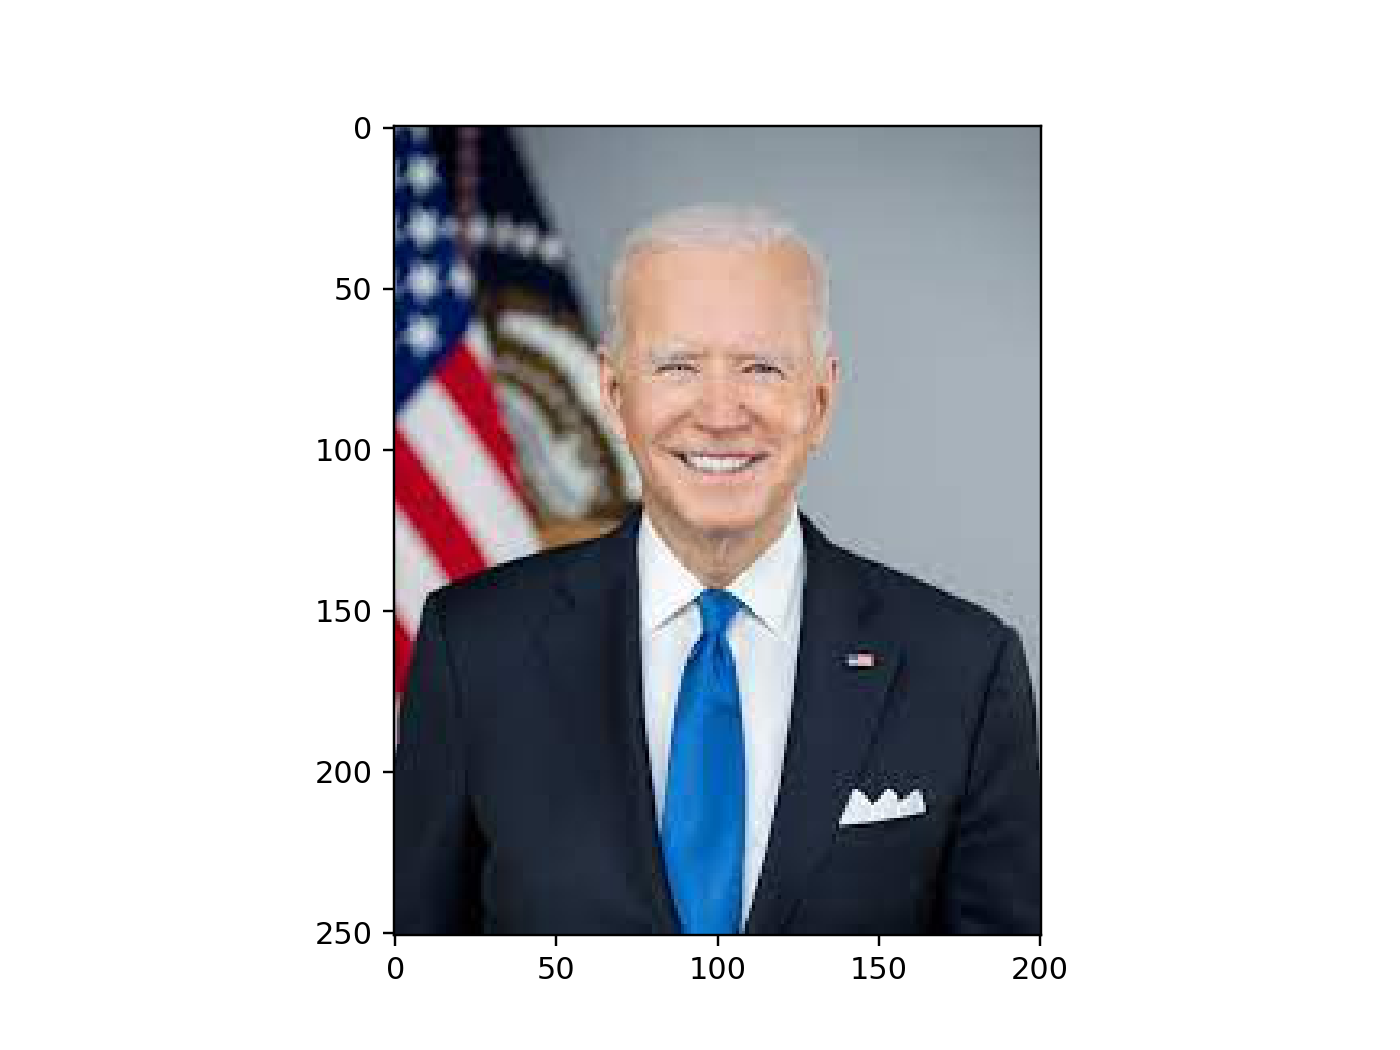

In [82]:
jb1 = cv2.imread("database/JB/1.jpg")[:,:,::-1] # The slicing part converts the BGR image to RGB
#cv2.imshow("test", pic) # Will have a window pop-up of the image. Press any key to continue
#cv2.waitKey(0)
#cv2.destroyAllWindows()
print("jb shape:", jb1.shape)
plt.imshow(jb1)

jb2 shape: (558, 992, 3)


<IPython.core.display.Javascript object>


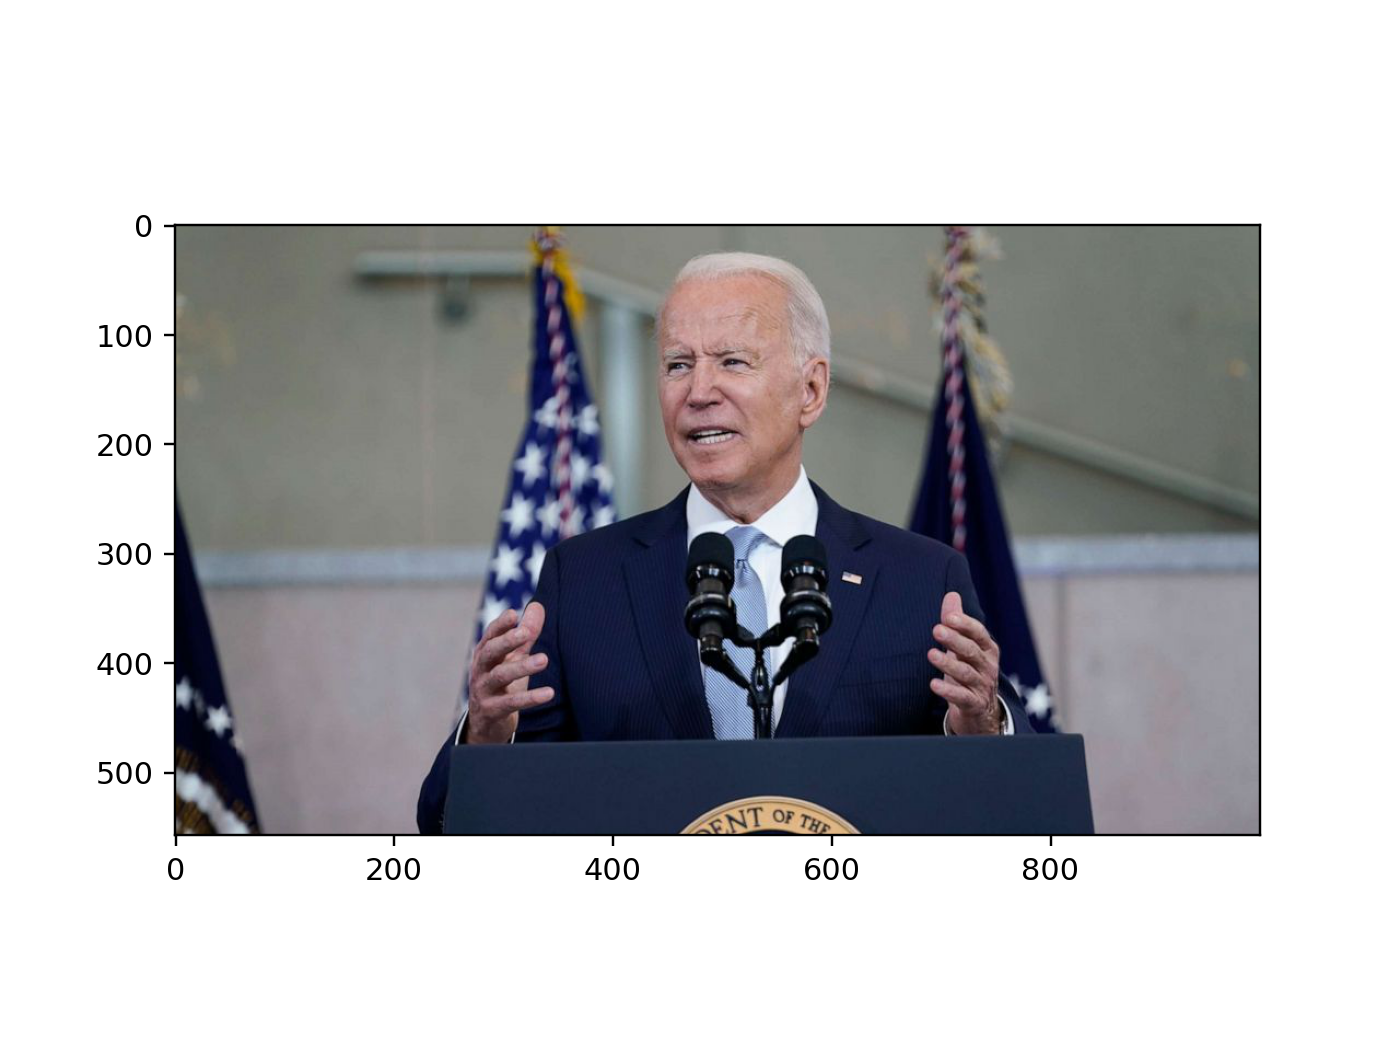

In [83]:
jb2 = cv2.imread("database/JB/2.jpg")[:,:,::-1] # The slicing part converts the BGR image to RGB
#cv2.imshow("test", pic) # Will have a window pop-up of the image. Press any key to continue
#cv2.waitKey(0)
#cv2.destroyAllWindows()
print("jb2 shape:", jb2.shape)
plt.imshow(jb2)

## Converting Face to Vectors

In [84]:
boxes, probabilities, landmarks = db.convertPictoFaces(jb1)

<IPython.core.display.Javascript object>


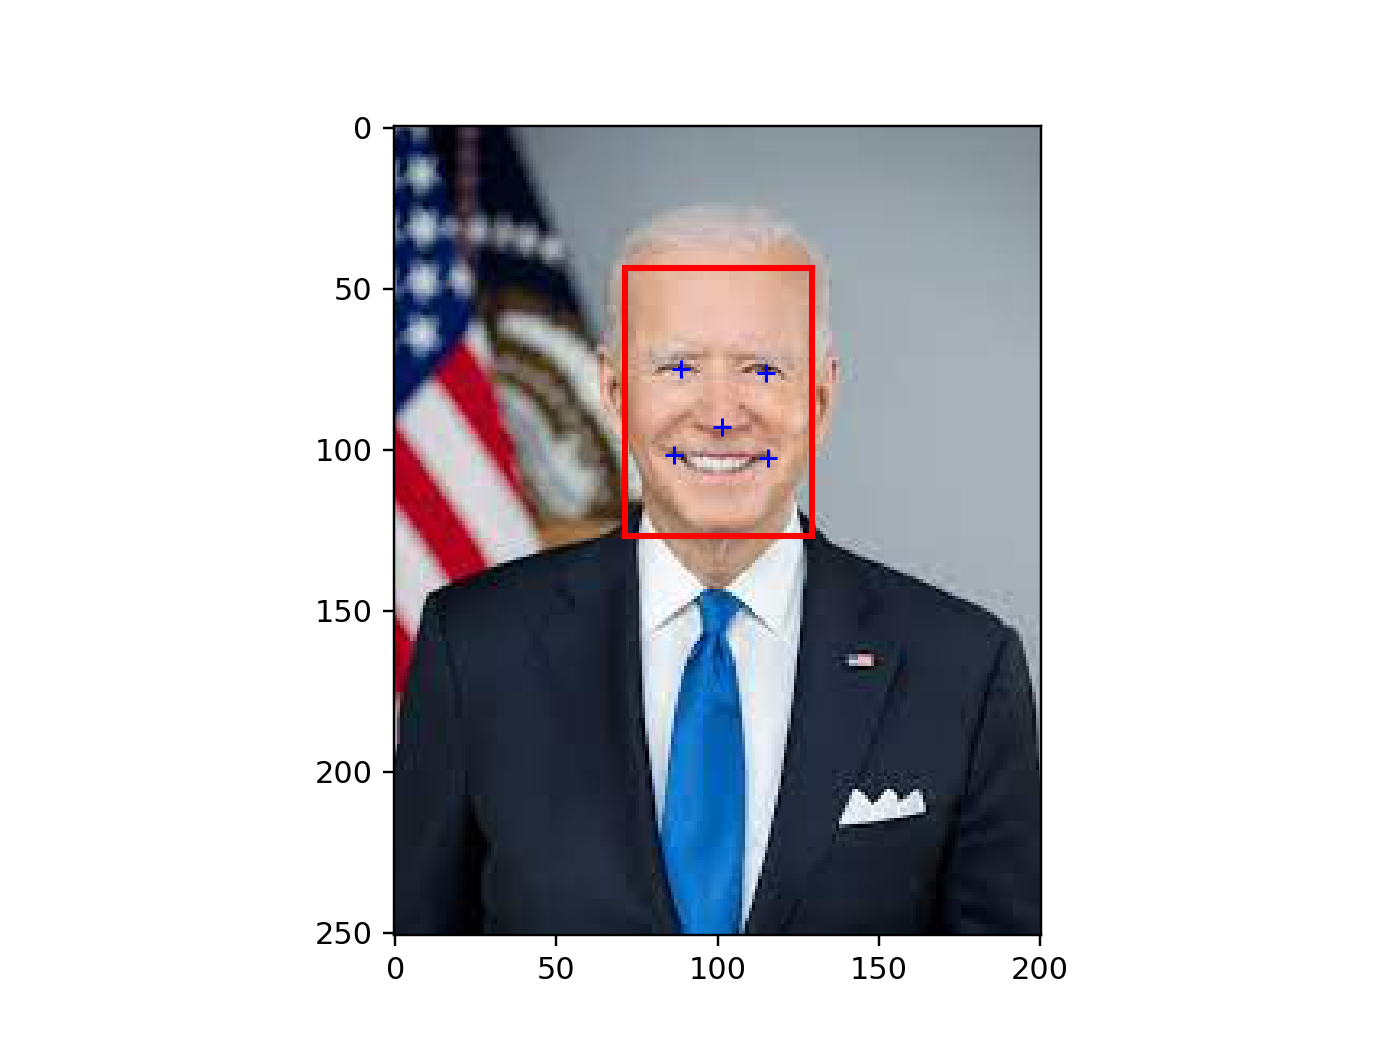

In [85]:
db.drawFaces(jb1, boxes, probabilities, landmarks)

In [86]:
jb1_vd = db.convertFacetoVD(jb1, boxes)
#print(jb1_vd)

In [87]:
db.addEntry(pic_vd = jb1_vd, name="JB")

In [88]:
boxes, probabilities, landmarks = db.convertPictoFaces(jb2)

<IPython.core.display.Javascript object>


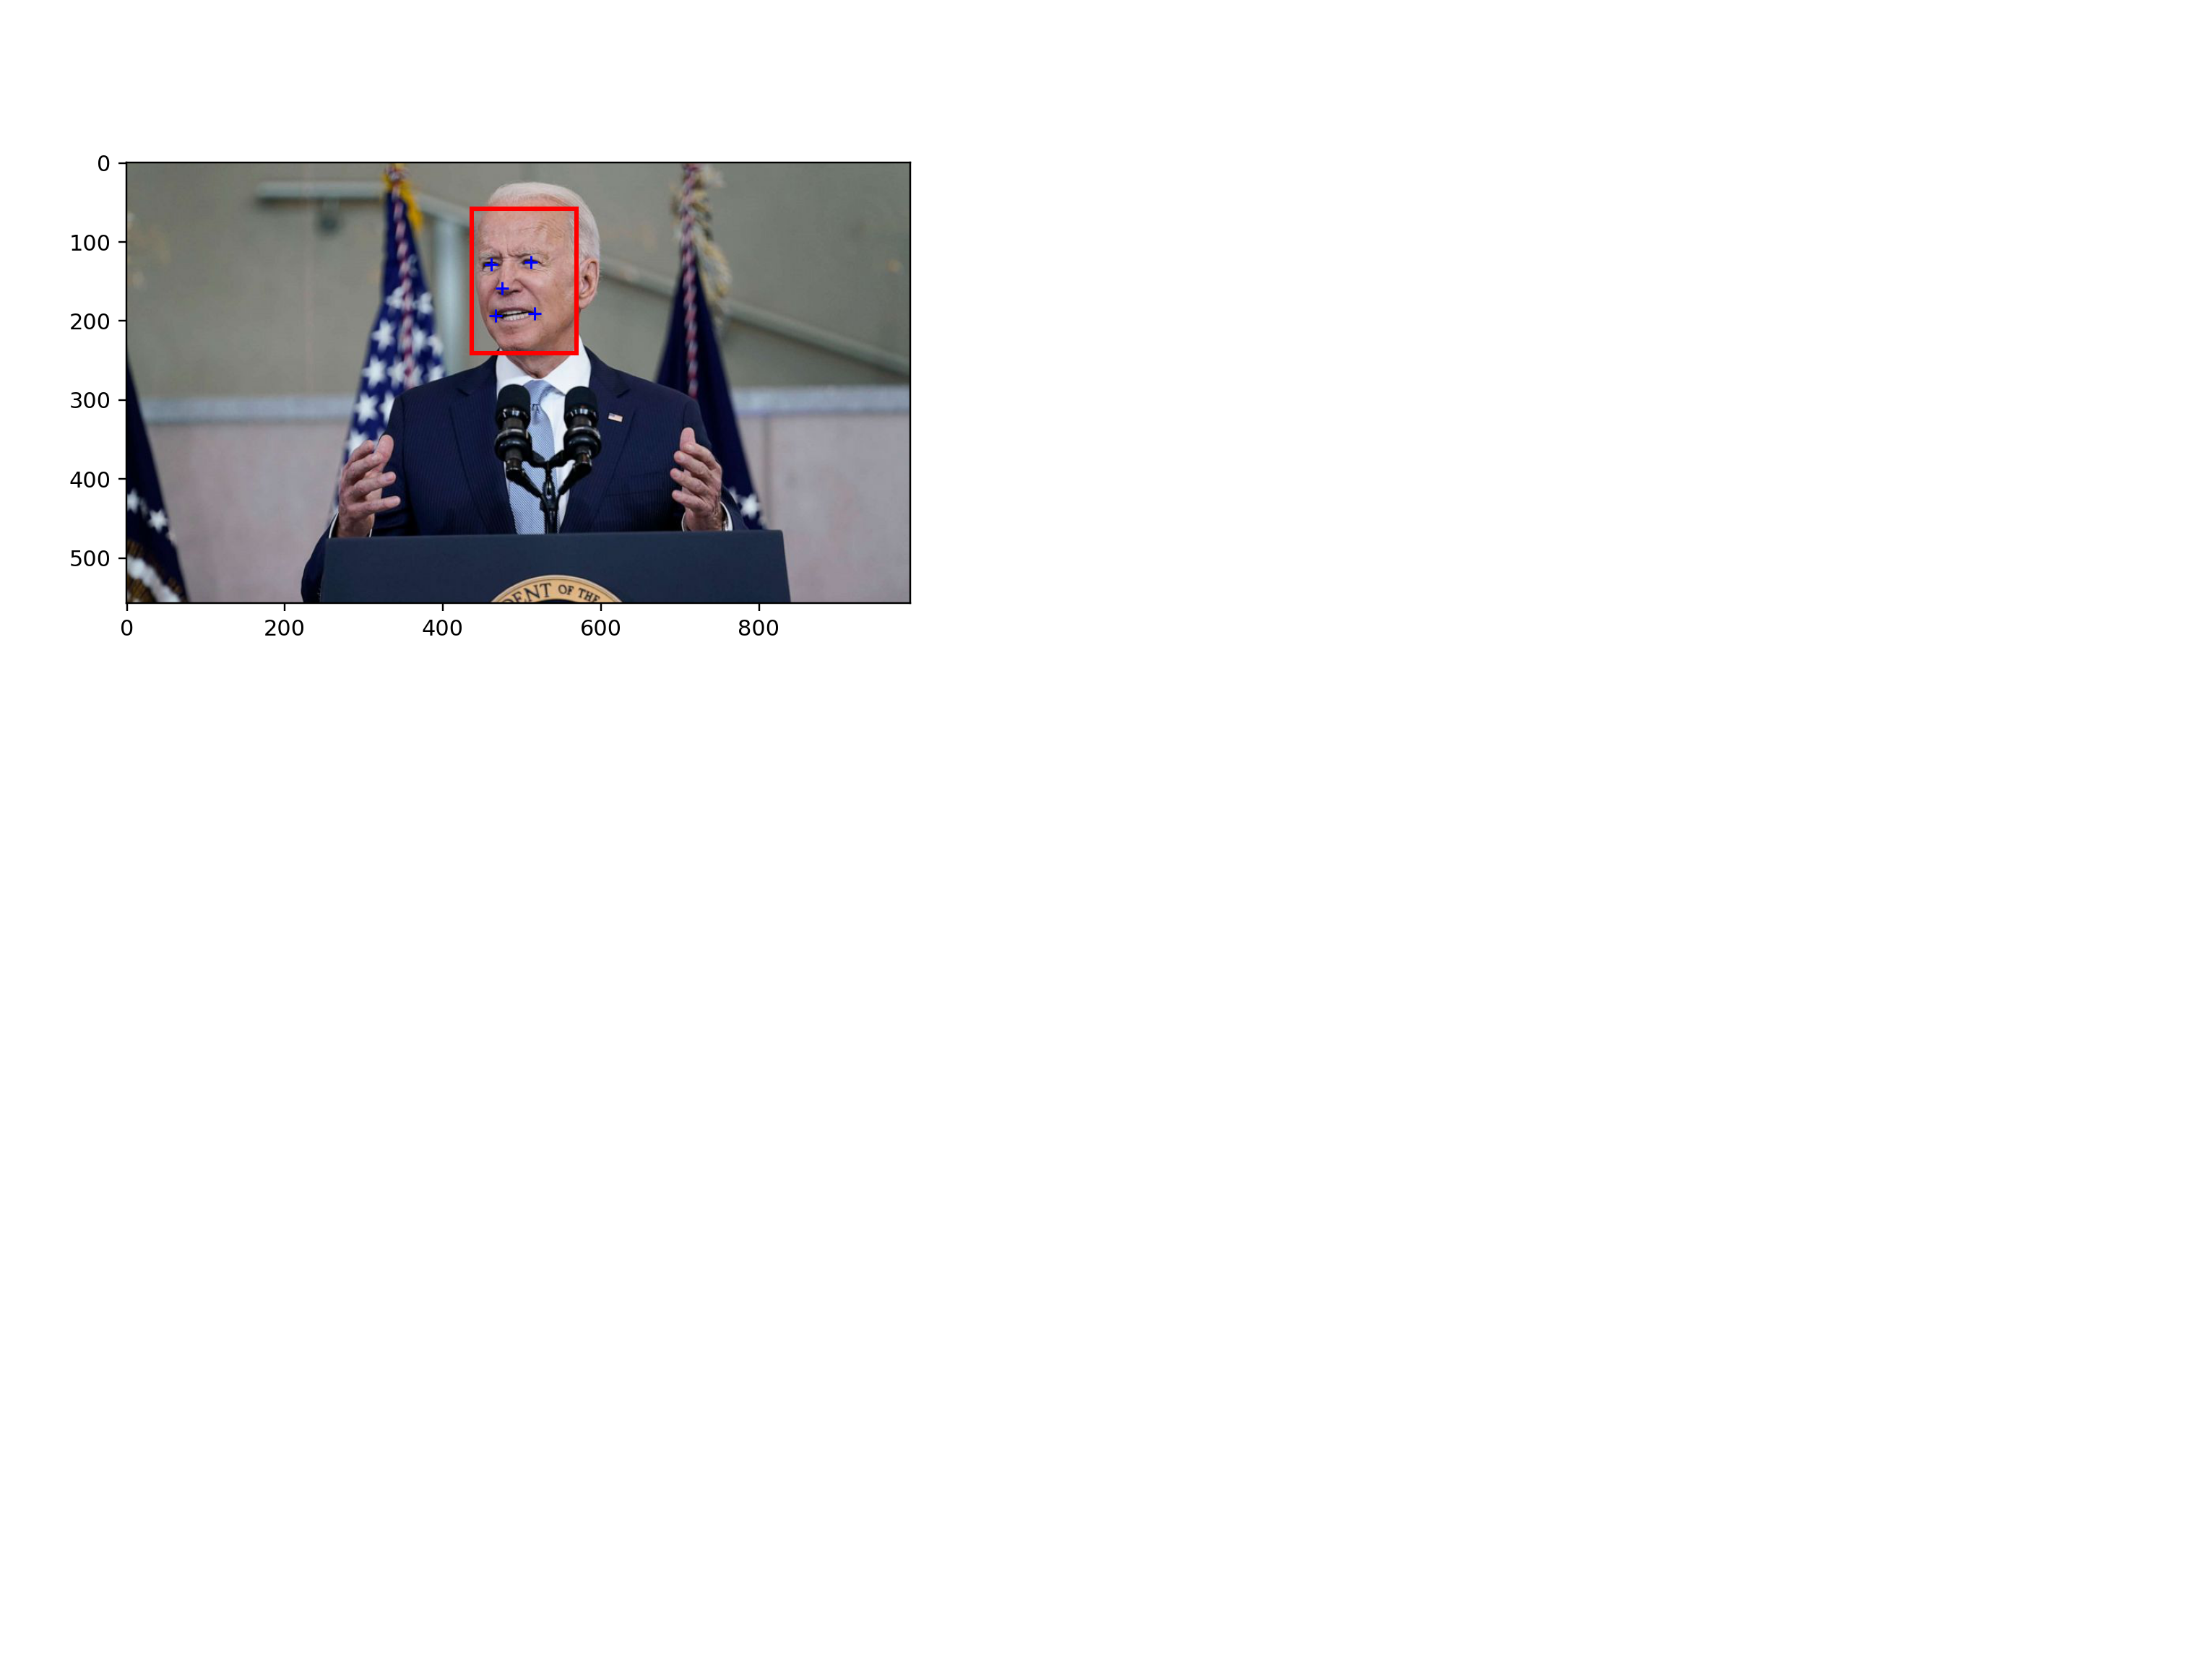

In [89]:
db.drawFaces(jb2, boxes, probabilities, landmarks)

In [90]:
jb2_vd = db.convertFacetoVD(jb2, boxes)
#print(jb2_vd)

In [91]:
db.addEntry(pic_vd = jb2_vd, name="JB")

In [92]:
len(db.storage["JB"].vector_descriptors)

2

In [93]:
#db.removeEntry(index=0, name="JB") # DELETING AN ENTRY

In [ ]:
#len(db.storage["JB"].vector_descriptors)

In [ ]:
#db.storage["JB"].averageVD

In [ ]:
#db.storage["JB"].vector_descriptors

In [ ]:
#jb2_vd

## Testing db.match() on different photos

jb5 shape: (174, 290, 3)


<IPython.core.display.Javascript object>


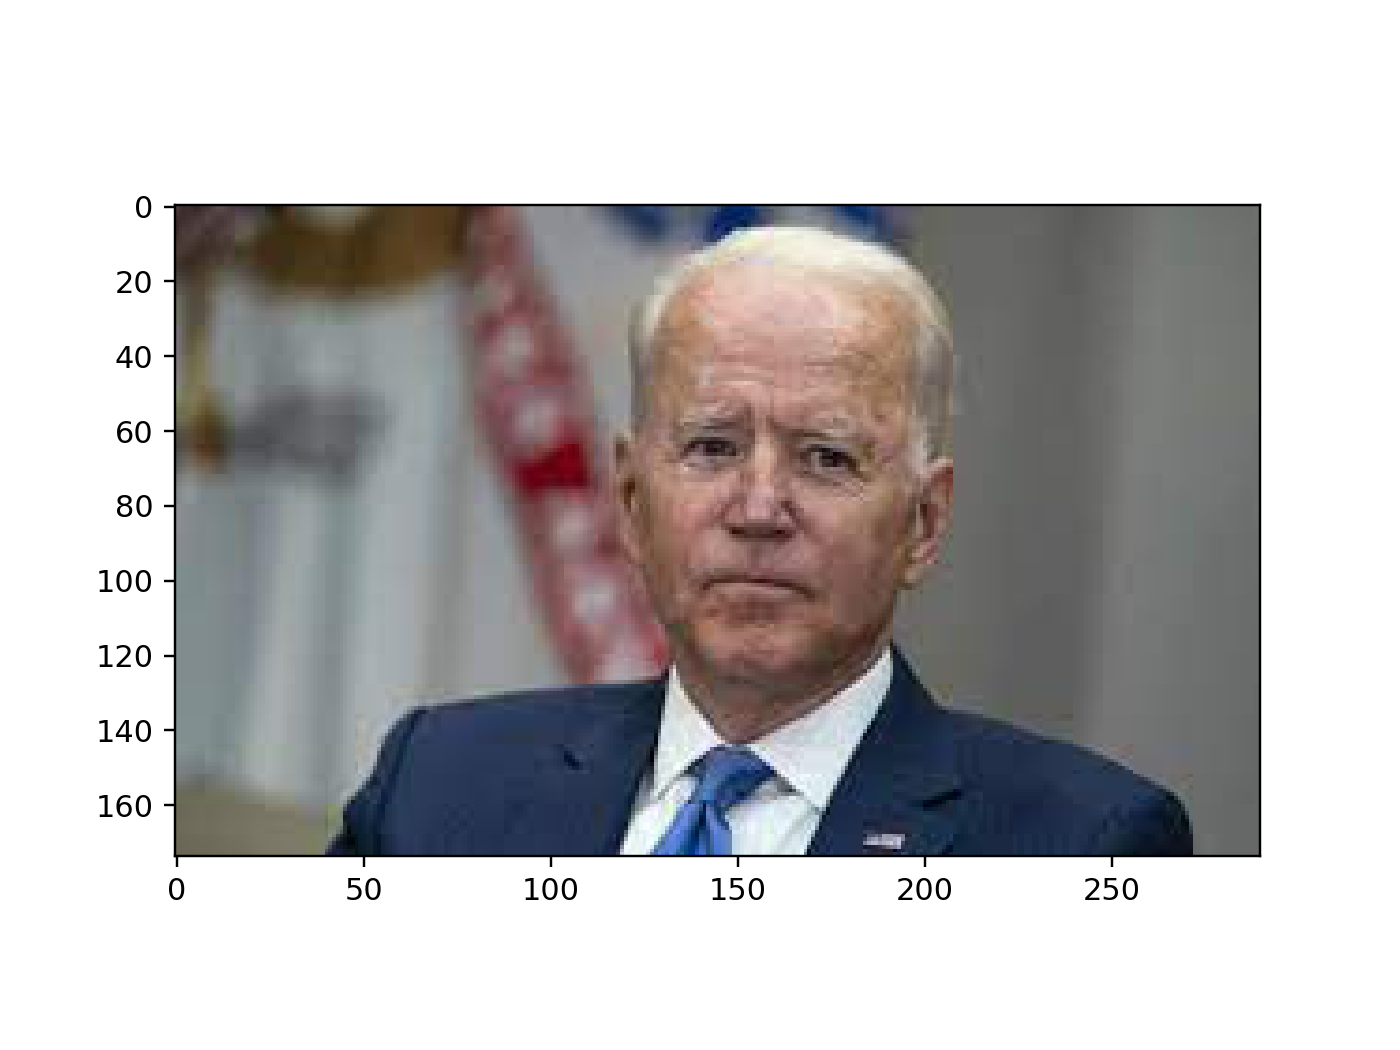

In [94]:
jb5 = cv2.imread("database/JB/5.jpg")[:,:,::-1] # The slicing part converts the BGR image to RGB
#cv2.imshow("test", pic) # Will have a window pop-up of the image. Press any key to continue
#cv2.waitKey(0)
#cv2.destroyAllWindows()
print("jb5 shape:", jb5.shape)
plt.imshow(jb5)

In [95]:
boxes, probabilities, landmarks = db.convertPictoFaces(jb5)

<IPython.core.display.Javascript object>


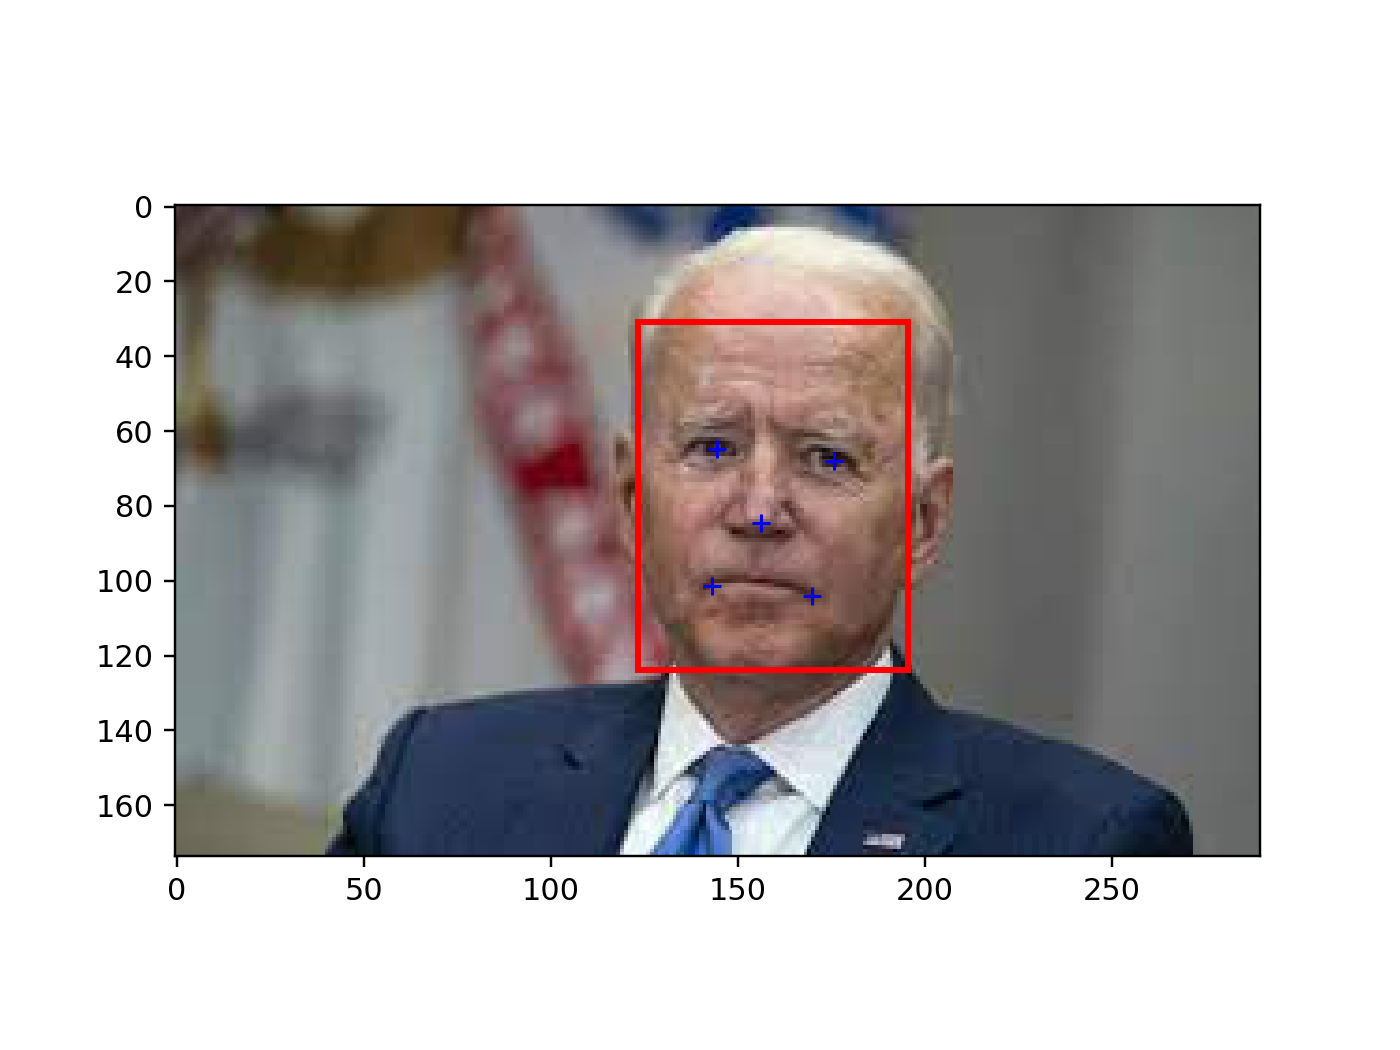

In [96]:
db.drawFaces(jb5, boxes, probabilities, landmarks)

In [97]:
jb5_vd = db.convertFacetoVD(jb5, boxes)

In [98]:
db.match(jb5_vd)

Cosine Similarity for JB : 0.12664473056793213


'JB'

ws1 shape: (1397, 941, 3)
[0.99998367]
[[186.55293 157.92001 791.9086  959.04987]]


<IPython.core.display.Javascript object>


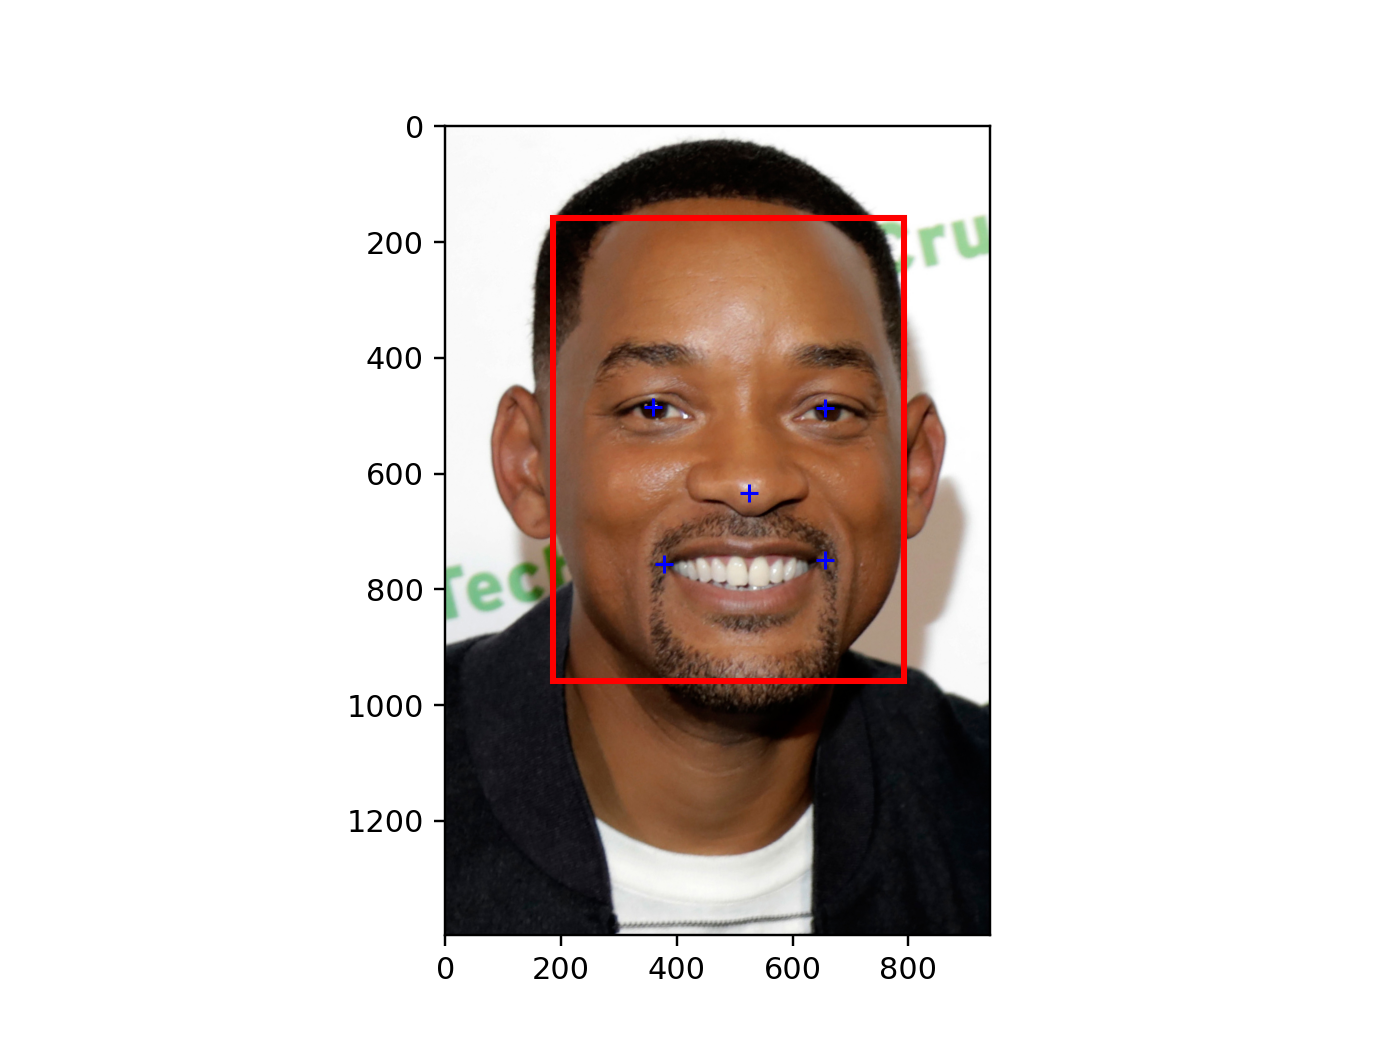

In [99]:
ws1 = cv2.imread("database/WS/1.jpg")[:,:,::-1] # The slicing part converts the BGR image to RGB
#cv2.imshow("test", pic) # Will have a window pop-up of the image. Press any key to continue
#cv2.waitKey(0)
#cv2.destroyAllWindows()
print("ws1 shape:", ws1.shape)
#plt.imshow(ws1)
boxes, probabilities, landmarks = db.convertPictoFaces(ws1)
print(probabilities)
print(boxes)
db.drawFaces(ws1, boxes, probabilities, landmarks)
ws1_vd = db.convertFacetoVD(ws1, boxes)

In [100]:
db.match(ws1_vd)

Cosine Similarity for JB : 1.123991385102272


'No one!'

# Messing around with .glob of pathlib

In [101]:
# glob all of the text files in the present directory
# that start with 'test' and end with '.txt'
from pathlib import Path
root_dir = Path('.')
#print(root_dir)
# glob all of the text files in the present directory
# that start with 'test' and end with '.txt'
root_dir = Path('.')
folders = root_dir.glob('database/*')  # this produces a generator
# VERY IMPORTANT: YOU CAN ONLY USE GENERATORS ONCE BEFORE THEY EXPIRE

In [ ]:
sorted(folders) # VERY IMPORTANT: YOU CAN ONLY USE GENERATORS ONCE BEFORE THEY EXPIRE

In [ ]:
# glob all of the text files in the present directory
# that start with 'test' and end with '.txt'
from pathlib import Path
root_dir = Path('.')
#print(root_dir)
# glob all of the text files in the present directory
# that start with 'test' and end with '.txt'
root_dir = Path('.')
files = root_dir.glob('database/*/*.png')  # this produces a generator

In [ ]:
sorted(files)

In [ ]:
list_of_files = []
for path in (sorted(folders)):
    list_of_files += path.glob('*')

In [ ]:
#list_of_files

# Loading Database with all pictures of people in "database" folder

In [102]:
db = Database()

In [103]:
db.storage

{}

In [104]:
from pathlib import Path
root_dir = Path('.')
folders = root_dir.glob('database/*')  # this produces a generator
# VERY IMPORTANT: YOU CAN ONLY USE GENERATORS ONCE BEFORE THEY EXPIRE

list_of_files = []
for path in (sorted(folders)):
    list_of_files += path.glob('*')

In [105]:
list_of_files

[WindowsPath('database/BS/1.jpg'),
 WindowsPath('database/BS/2.jpg'),
 WindowsPath('database/BS/3.jpg'),
 WindowsPath('database/BS/4.jpg'),
 WindowsPath('database/BS/6.jpg'),
 WindowsPath('database/CG/1.jpg'),
 WindowsPath('database/JB/1.jpg'),
 WindowsPath('database/JB/10.jpg'),
 WindowsPath('database/JB/11.jpg'),
 WindowsPath('database/JB/2.jpg'),
 WindowsPath('database/JB/3.jpg'),
 WindowsPath('database/JB/4.jpg'),
 WindowsPath('database/JB/5.jpg'),
 WindowsPath('database/JB/6.jpg'),
 WindowsPath('database/JB/7.jpg'),
 WindowsPath('database/JB/8.jpg'),
 WindowsPath('database/JB/9.jpg'),
 WindowsPath('database/SO/1.png'),
 WindowsPath('database/SO/2.jpg'),
 WindowsPath('database/SO/3.jpg'),
 WindowsPath('database/SO/4.jpg'),
 WindowsPath('database/SO/5.png'),
 WindowsPath('database/TS/1.jpg'),
 WindowsPath('database/TS/3.jpg'),
 WindowsPath('database/TS/4.jpg'),
 WindowsPath('database/TS/5.jpg'),
 WindowsPath('database/WS/1.jpg'),
 WindowsPath('database/WS/2.jpg'),
 WindowsPath('data

In [106]:
# Getting the name of a WindowsPath object
name =  str(list_of_files[20])[9:11]

In [107]:
pic_vd.shape

(512,)

In [108]:
for path in list_of_files:
    name = str(path)[9:11]
    print("Current Path:", path, "    Current Name:", name)
    pic = cv2.imread(str(path))[:,:,::-1] # The slicing part converts the BGR image to RGB
    boxes, probabilities, landmarks = db.convertPictoFaces(pic)
    #db.drawFaces(pic, boxes, probabilities, landmarks)
    pic_vd = db.convertFacetoVD(pic, boxes)
    db.addEntry(pic_vd=pic_vd, name=name)
    '''if "CG" in db.storage:
        print("Len:", len(db.storage["CG"].vector_descriptors))'''

Current Path: database\BS\1.jpg     Current Name: BS
Current Path: database\BS\2.jpg     Current Name: BS
Current Path: database\BS\3.jpg     Current Name: BS
Current Path: database\BS\4.jpg     Current Name: BS
Current Path: database\BS\6.jpg     Current Name: BS
Current Path: database\CG\1.jpg     Current Name: CG
Current Path: database\JB\1.jpg     Current Name: JB
Current Path: database\JB\10.jpg     Current Name: JB
Current Path: database\JB\11.jpg     Current Name: JB
Current Path: database\JB\2.jpg     Current Name: JB
Current Path: database\JB\3.jpg     Current Name: JB
Current Path: database\JB\4.jpg     Current Name: JB
Current Path: database\JB\5.jpg     Current Name: JB
Current Path: database\JB\6.jpg     Current Name: JB
Current Path: database\JB\7.jpg     Current Name: JB
Current Path: database\JB\8.jpg     Current Name: JB
Current Path: database\JB\9.jpg     Current Name: JB
Current Path: database\SO\1.png     Current Name: SO
Current Path: database\SO\2.jpg     Current 

In [109]:
len(db.storage["CG"].vector_descriptors)

1

In [110]:
[(k, len(v.vector_descriptors)) for k, v in db.storage.items()]

[('BS', 5), ('CG', 1), ('JB', 11), ('SO', 5), ('TS', 4), ('WS', 5)]

# Testing Loaded Database

pic shape: (168, 299, 3)
Probabilities: [0.99994385]
Boxes: [[125.71856   10.710726 169.71982   75.02039 ]]


<IPython.core.display.Javascript object>


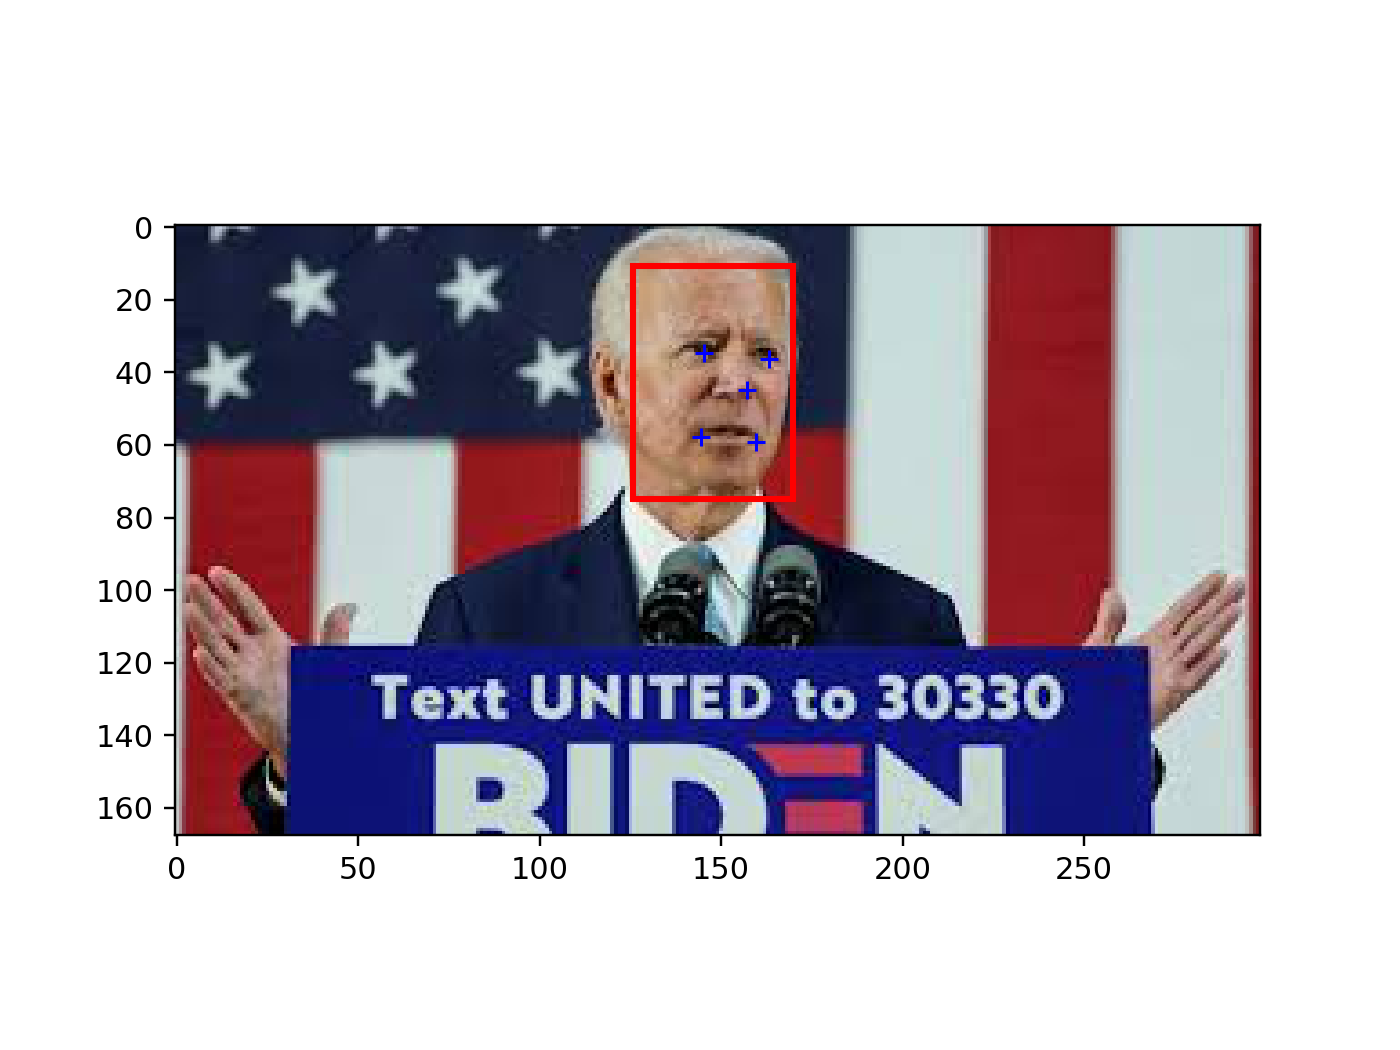

In [111]:
pic = cv2.imread("test-photos/joe_biden_test_image.jpg")[:,:,::-1] # The slicing part converts the BGR image to RGB
#pic = cv2.imread("database/CG/1.jpg")[:,:,::-1] # The slicing part converts the BGR image to RGB
print("pic shape:", pic.shape)
#plt.imshow(ws1)
boxes, probabilities, landmarks = db.convertPictoFaces(pic)
print("Probabilities:", probabilities)
print("Boxes:", boxes)
db.drawFaces(pic, boxes, probabilities, landmarks)
pic_vd = db.convertFacetoVD(pic, boxes)
#print("Pic Vector:", pic_vd)

In [112]:
db.match(pic_vd, cutoff=0.5)

Cosine Similarity for BS : 0.9789883010089397
Cosine Similarity for CG : 1.0655824840068817
Cosine Similarity for JB : 0.17714035511016846
Cosine Similarity for SO : 0.8571572005748749
Cosine Similarity for TS : 1.0414071828126907
Cosine Similarity for WS : 1.1086047291755676


'JB'

# Storing & Loading Database

In [124]:
import pickle

In [125]:
# SAVING DATABASE

with open("database.pkl", "wb") as file:
    pickle.dump(db, file)

'''file = open("database.pkl", "wb")
pickle.dump(db, file)
file.close()'''

'file = open("database.pkl", "wb")\npickle.dump(db, file)\nfile.close()'

In [126]:
# LOADING DATABASE

with open("database.pkl", "rb") as file:
    output = pickle.load(file)

'''file = open("database.pkl", "rb")
output = pickle.load(file)'''
db = output
[(k, len(v.vector_descriptors)) for k, v in db.storage.items()]

[('BS', 5), ('CG', 1), ('JB', 11), ('SO', 5), ('TS', 4), ('WS', 5)]